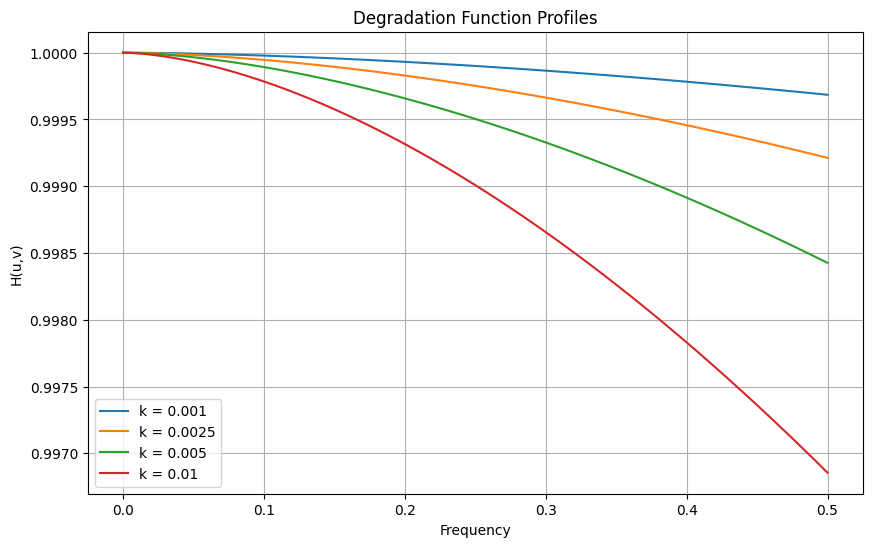

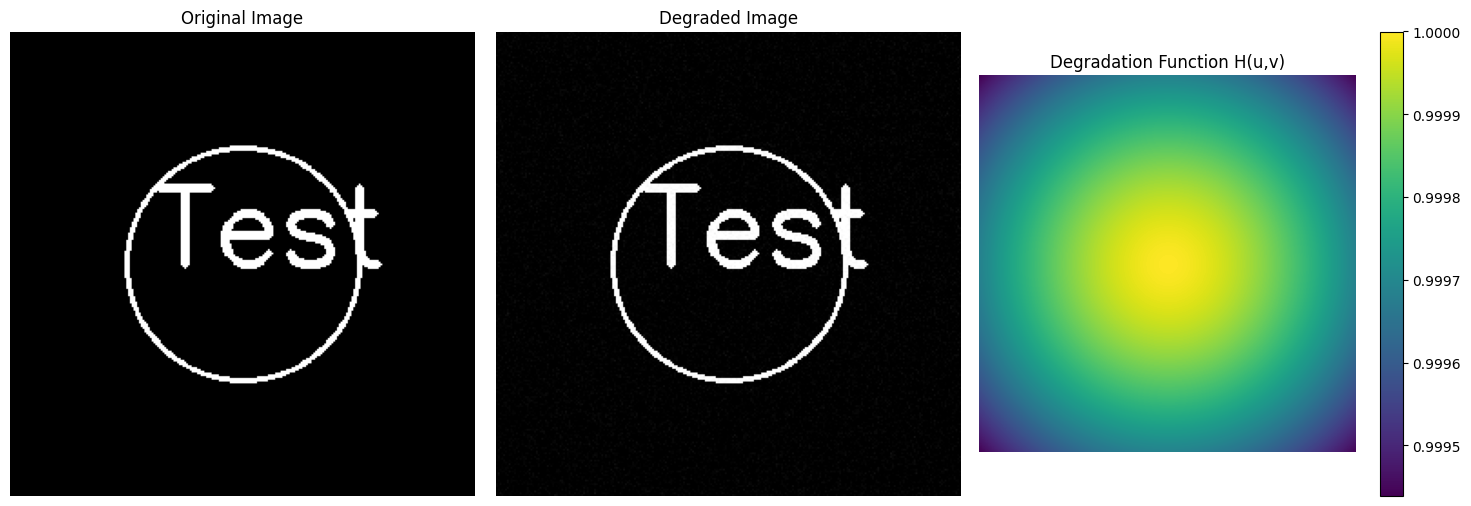


Degradation parameters:
k = 0.001 (turbulence strength)
noise std = 0.02


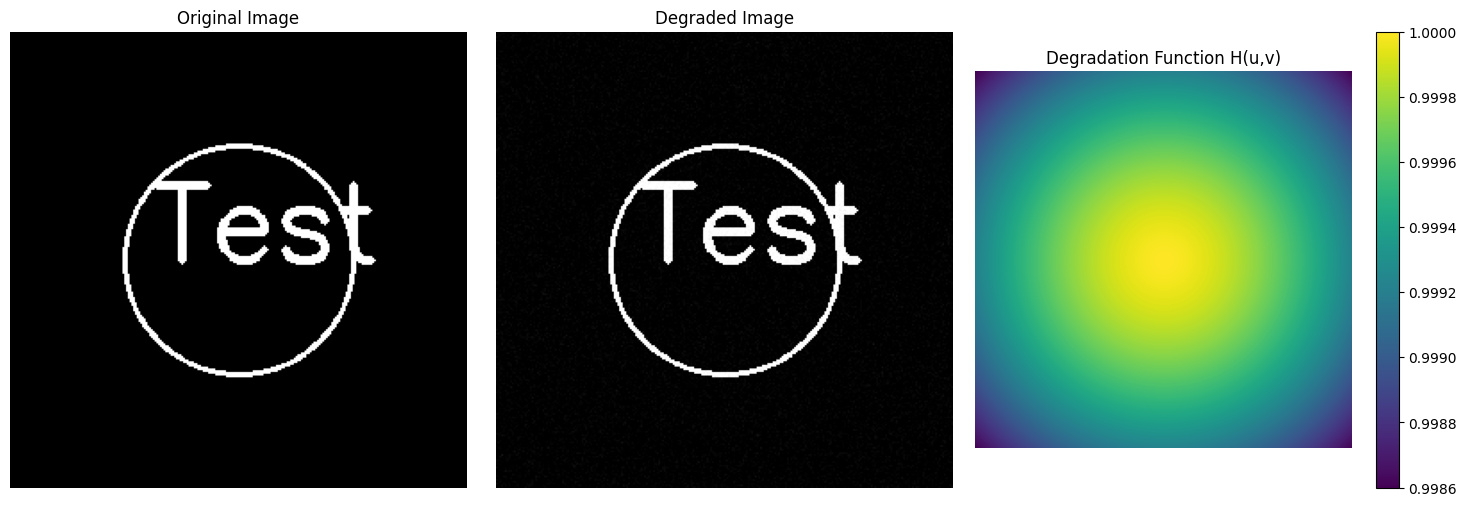


Degradation parameters:
k = 0.0025 (turbulence strength)
noise std = 0.02


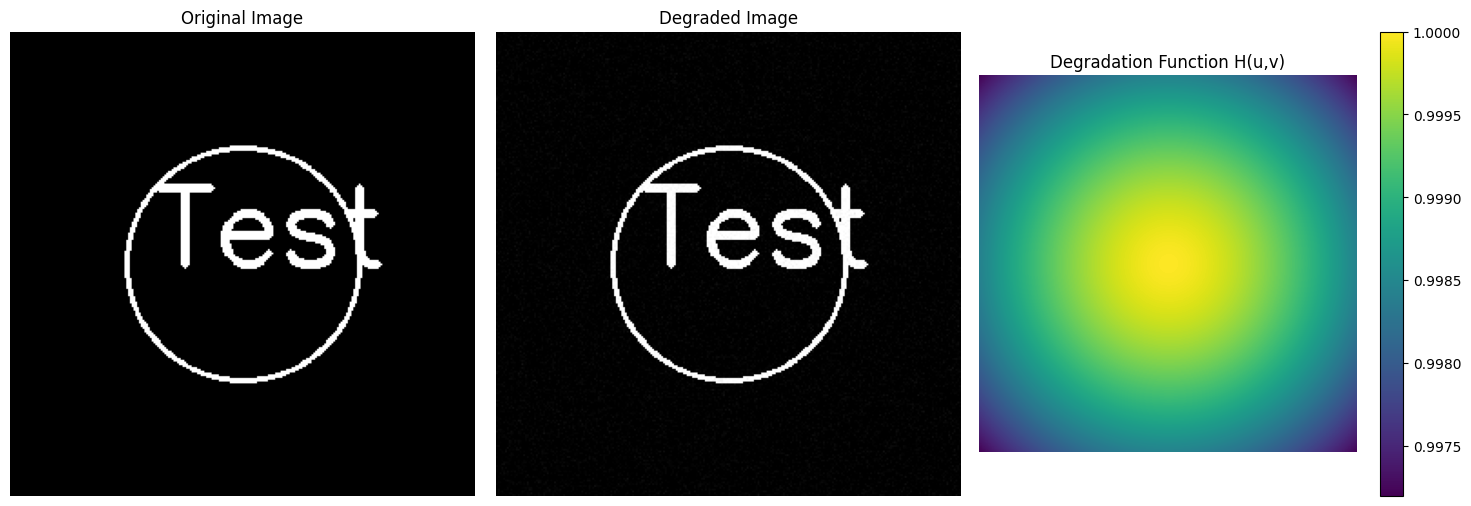


Degradation parameters:
k = 0.005 (turbulence strength)
noise std = 0.02


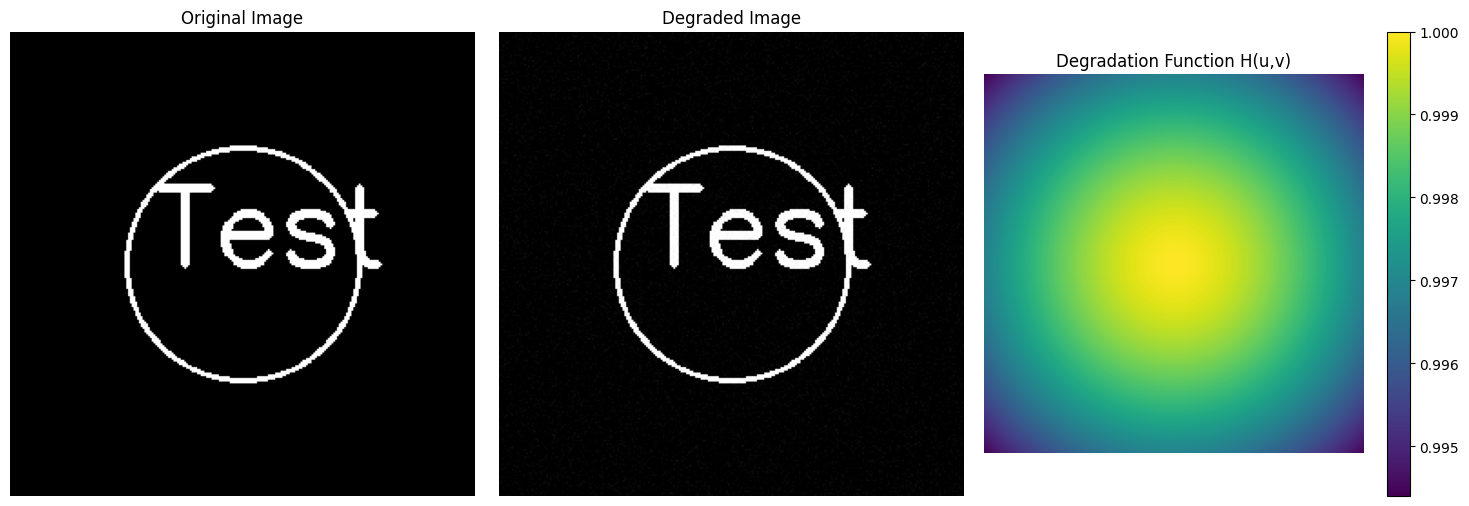


Degradation parameters:
k = 0.01 (turbulence strength)
noise std = 0.02


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np

def load_test_image():
    """Load a test image from URL or create one if failed."""
    try:
        # Try to load Lena image from URL
        url = "https://raw.githubusercontent.com/scikit-image/scikit-image/master/skimage/data/lena.png"
        img_arr = np.asarray(bytearray(urlopen(url).read()), dtype=np.uint8)
        img = cv2.imdecode(img_arr, cv2.IMREAD_GRAYSCALE)

        # Resize to reasonable dimensions
        img = cv2.resize(img, (256, 256))
        return img
    except:
        # If loading fails, create a simple pattern
        img = np.zeros((256, 256), dtype=np.uint8)
        cv2.putText(img, 'Test', (80, 128), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 3)
        cv2.circle(img, (128, 128), 64, 255, 2)
        return img

def create_frequency_grid(shape):
    """Create frequency grid for the given image shape."""
    rows, cols = shape
    u = np.fft.fftfreq(cols)
    v = np.fft.fftfreq(rows)
    u, v = np.meshgrid(u, v)
    return u, v

def atmospheric_degradation_function(u, v, k=0.0025):
    """
    Calculate atmospheric degradation function H(u,v).
    H(u,v) = exp(-k(u^2 + v^2)^(5/6))
    """
    r_squared = u**2 + v**2
    H = np.exp(-k * (r_squared)**(5/6))
    return H

def add_gaussian_noise(image, mean=0, std=0.01):
    """Add Gaussian noise N(u,v) to the image."""
    noise = np.random.normal(mean, std, image.shape)
    return image + noise

def degrade_image(image, k=0.0025, noise_std=0.01):
    """
    Apply atmospheric turbulence degradation to image.
    G(u,v) = H(u,v)F(u,v) + N(u,v)
    """
    # Convert image to float and normalize
    img_float = image.astype(float) / 255.0

    # Calculate frequency grid
    u, v = create_frequency_grid(image.shape)

    # Calculate degradation function
    H = atmospheric_degradation_function(u, v, k)

    # Apply degradation in frequency domain
    F = np.fft.fft2(img_float)
    G = H * F

    # Transform back to spatial domain
    degraded = np.real(np.fft.ifft2(G))

    # Add noise
    degraded = add_gaussian_noise(degraded, std=noise_std)

    # Clip and convert back to uint8
    degraded = np.clip(degraded * 255, 0, 255).astype(np.uint8)

    return degraded, H

def visualize_results(original, degraded, H):
    """Visualize original, degraded images and degradation function."""
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(131)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Degraded image
    plt.subplot(132)
    plt.imshow(degraded, cmap='gray')
    plt.title('Degraded Image')
    plt.axis('off')

    # Degradation function
    plt.subplot(133)
    plt.imshow(np.fft.fftshift(H), cmap='viridis')
    plt.title('Degradation Function H(u,v)')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_degradation_profiles(k_values):
    """Plot degradation function profiles for different k values."""
    plt.figure(figsize=(10, 6))

    # Create frequency array
    freq = np.linspace(0, 0.5, 100)
    u = freq
    v = np.zeros_like(freq)

    for k in k_values:
        H = atmospheric_degradation_function(u, v, k)
        plt.plot(freq, H, label=f'k = {k}')

    plt.xlabel('Frequency')
    plt.ylabel('H(u,v)')
    plt.title('Degradation Function Profiles')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Load test image
    image = load_test_image()

    # Test different degradation levels
    k_values = [0.001, 0.0025, 0.005, 0.01]
    noise_std = 0.02

    # Plot degradation function profiles
    plot_degradation_profiles(k_values)

    # Apply and visualize degradation for each k value
    for k in k_values:
        degraded, H = degrade_image(image, k=k, noise_std=noise_std)
        visualize_results(image, degraded, H)

        # Print degradation parameters
        print(f"\nDegradation parameters:")
        print(f"k = {k} (turbulence strength)")
        print(f"noise std = {noise_std}")

if __name__ == "__main__":
    main()